In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('..')

from astroLuSt.database_interface import alerceinterface
from astroLuSt.database_interface import eleanorinterface
from astroLuSt.database_interface import gaiainterface
from astroLuSt.database_interface import lightkurveinterface
from astroLuSt.database_interface import simbadinterface

import importlib
importlib.reload(alerceinterface)
importlib.reload(eleanorinterface)
importlib.reload(gaiainterface)
importlib.reload(lightkurveinterface)
importlib.reload(simbadinterface)

#style for plotting
plt.style.use('astroLuSt.styles.LuSt_style')

In [2]:
targets = [
    "KIC 5006817", "RR Lyr", "TV Boo"
]

# SimbadDatabaseInterface

In [3]:
SDI = simbadinterface.SimbadDatabaseInterface()
ids = SDI.get_ids(
    targets
)
tics = SDI.df_ids["TIC"]
print(tics)

INFO: catalog is None. Corresponding id: G 125-7
0    122447138
1    159717514
2    168709463
Name: TIC, dtype: object


# EleanorDatabaseInterface

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



######################################################################
INFO: Started Extracting {'tic': '122447138'} (chunk 1/1 - target 0/2) at 2023-10-22T12:43:10
Found star in Sector(s) 14 40 41


No eleanor postcard has been made for your target (yet). Using TessCut instead.
No eleanor postcard has been made for your target (yet). Using TessCut instead.
No eleanor postcard has been made for your target (yet). Using TessCut instead.

INFO: Finished Extracting {'tic': '122447138'} (chunk 1/1 - target 0/2) at 2023-10-22T12:43:28
Required time: 0 days 00:00:18
######################################################################
INFO: Total estimated runtime for 2 repeats: 0 days 00:00:36

######################################################################
INFO: Started Extracting {'tic': '159717514'} (chunk 1/1 - target 1/2) at 2023-10-22T12:43:28


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.4s remaining:    0.0s


Found star in Sector(s) 14 40 41


No eleanor postcard has been made for your target (yet). Using TessCut instead.
No eleanor postcard has been made for your target (yet). Using TessCut instead.
No eleanor postcard has been made for your target (yet). Using TessCut instead.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   33.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   33.6s finished
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



INFO: Finished Extracting {'tic': '159717514'} (chunk 1/1 - target 1/2) at 2023-10-22T12:43:44
Required time: 0 days 00:00:16
######################################################################
INFO: Total estimated runtime for 2 repeats: 0 days 00:00:34


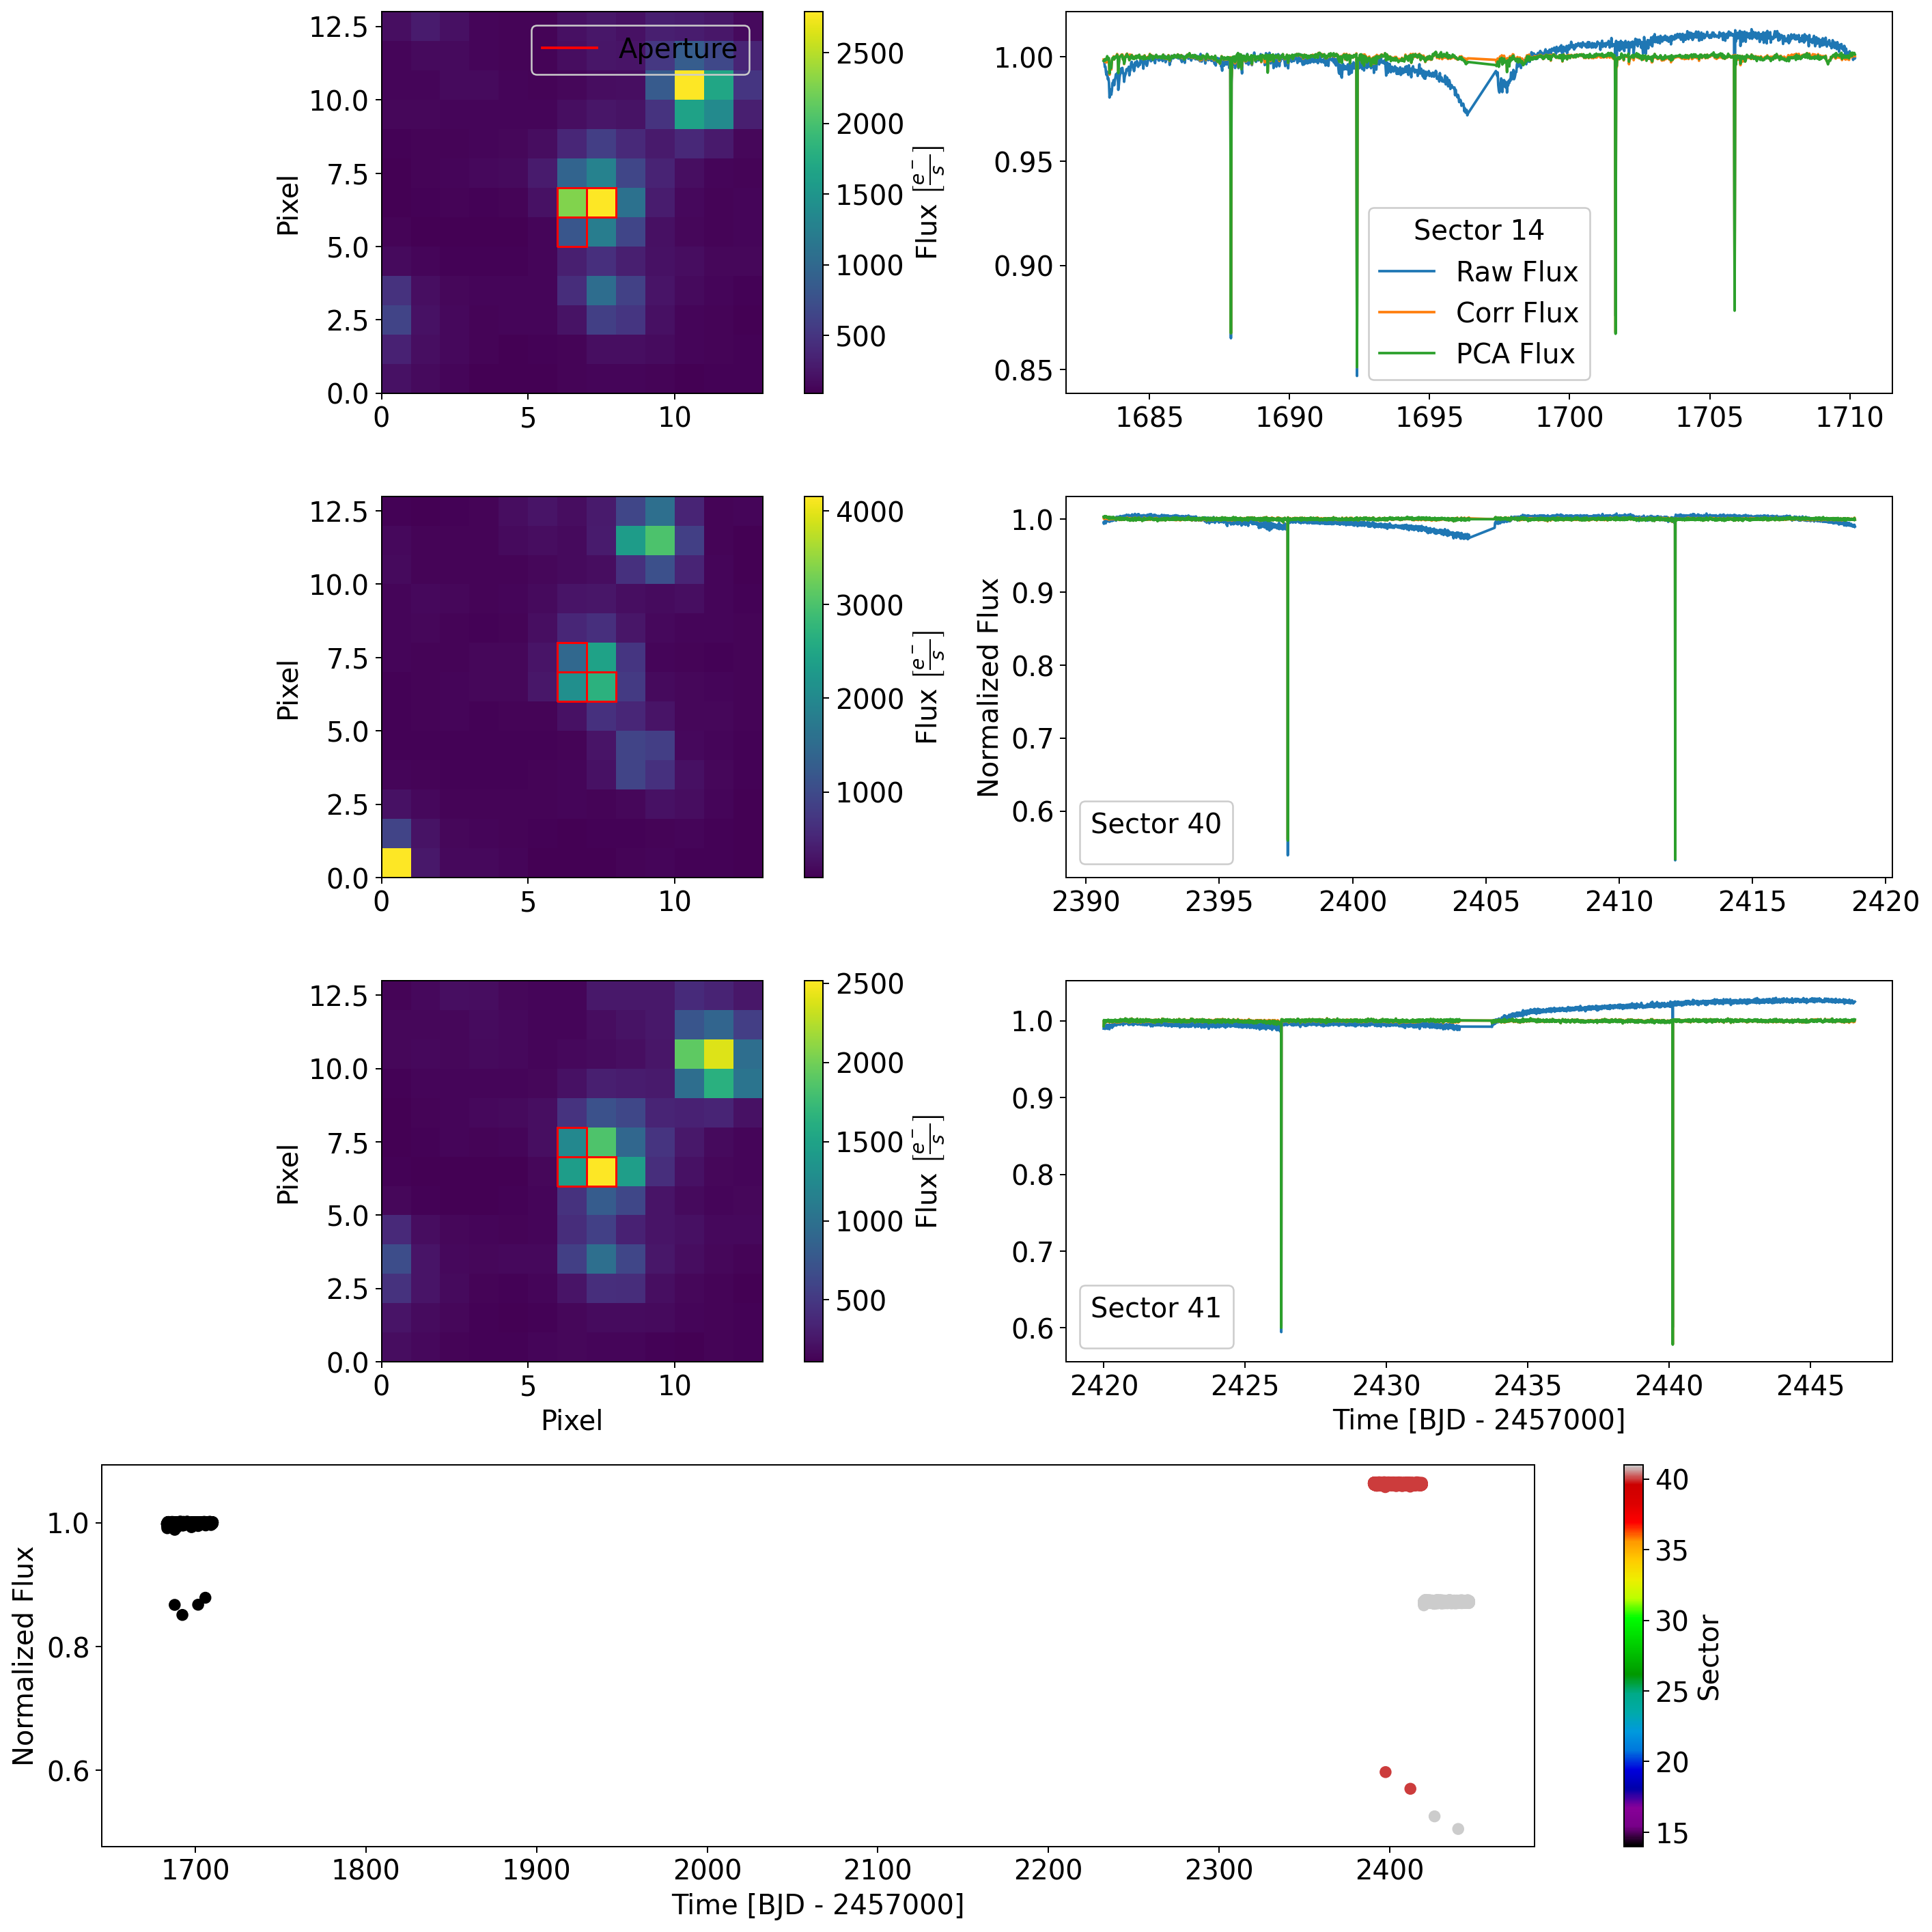

In [85]:
importlib.reload(eleanorinterface)

EDI = eleanorinterface.EleanorDatabaseInterface(
    n_jobs=1,
    redownload=True,
    verbose=3,
    )

# lc = EDI.extract_source(
#     sectors='all',
#     source_id={'tic':tics[0]},
#     targetdata_kwargs=dict(do_pca=True, aperture_mode='small'),
#     # save_kwargs=dict(directory='./data/', pd_savefunc='to_parquet'),
#     save_kwargs=None,
# )

lcs, headers, tpfs, aperture_masks = EDI.download(
    sectors=None,
    source_ids=[{'tic':tic} for tic in tics[-1:]],
    store_tpfs=True, store_aperture_masks=True,
    n_chunks=1,
    targetdata_kwargs=dict(do_pca=True, aperture_mode='small'),
    save_kwargs=dict(directory='./data/', pd_savefunc='to_parquet'),
)

fig, axs = EDI.plot_result(
    lcs=lcs[0],
    headers=headers[0],
    tpfs=tpfs[0],
    aperture_masks=aperture_masks[0],
)

plt.show()

# GaiaDatabaseInterface

In [ ]:
GID = gaiainterface.GaiaDatabaseInterface()
GID.gaia_crendetials = "../credentials_gaia.txt"

filter = "(jobs['phase'] == 'ERROR')"
GID.remove_all_jobs(pd_filter=filter, login_before=False, logout_after=False)


# AlerceDatabaseInterface

In [25]:
importlib.reload(alerceinterface)

ADI = alerceinterface.AlerceDatabaseInterface()

df = pd.DataFrame(
    data=np.array([
        [10054,	12.39495833, 27.02213889,],
        # [10088,	353.7751667, np.inf,],#41.10291667,],
        [10140,	16.294625,	 34.21841667,],
        # [10147,	359.6756667, 41.48880556,],
    ]),
    columns=['id', 'ra', 'dec']
)

df_ztf = ADI.crossmerge_by_coordinates(
    df_left=df,
    ra_colname='ra', dec_colname='dec', radius=1,
    sleep=2E-3,
    n_jobs=1, verbose=2
)

print(ADI.df_error_msgs_crossmerge)

ADI.download_lightcurves(
    df_ztf['oid_ztf'],
    save=False,
    # save='./data/',
    redownload=False,
    plot_result=True, save_plot=False, close_plots=False,
    sleep=2E-3,
    n_jobs=1, verbose=2
)
print(ADI.df_error_msgs_lcdownload)


Extracting #1/2

Extracting #2/2
  idx success original error message
0   0    True                   None
1   1    True                   None

Extracting ZTF22abbjfyk (#1/2)

Extracting ZTF17aabulmo (#2/2)
            ztf success                             original error message
0  ZTF22abbjfyk   False  WARNING: ./data/ZTF22abbjfyk.csv already exist...
1  ZTF17aabulmo   False  WARNING: ./data/ZTF17aabulmo.csv already exist...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


# LightkurveInterface

In [ ]:

importlib.reload(lightkurveinterface)
LKI = lightkurveinterface.LightkurveInterface(
    tics=tics.astype(np.float64)
)

LKI.download_lightcurves_tess(
    #saving data
    save=False,
    sectors='all',
    quality_expression="(datum.quality == 0)",
    include_aperture=False, include_tpf=False,
    #plotting
    plot_result=True,
    aperture_detail=50, ylims=None,
    fontsize=16, figsize=(16,9),
    save_plot=False,
    sleep=0,
    n_jobs=1, n_chunks=1,
    verbose=2
)

print(LKI.df_extraction_summary)